In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

In [68]:
#torch data set
class dataSetAll(Dataset):
    def __init__(self, yearLow, yearHigh,numFeat,numOut):
        #import data from CDC
        self.df = pd.read_csv("data\FluViewPhase2Data\WHO_NREVSS_Combined_prior_to_2015_16.csv")
        self.df = self.df[(yearLow <= self.df["YEAR"]) & (self.df["YEAR"] < yearHigh)]["TOTAL"]
        #turn data into features and output
        #features: 5 previous + one from last year for predicted
        #output: prediction for next time

        #create test data
        self.numFeat = numFeat #------------------------
        self.numOut = numOut
        self.data = np.asarray(self.df,dtype=np.float32)
        self.data = torch.as_tensor(self.data)

    def __len__(self):
        return len(self.data)-self.numFeat-self.numOut
    
    def __getitem__(self,idx):
        return self.data[idx:idx+self.numFeat],self.data[idx+self.numFeat+self.numOut-1]

In [76]:
#create data loaders
numFeat = 10
numOut = 1
train_data = dataSetAll(1900,2013,numFeat,numOut)
test_data = dataSetAll(2013,2100,numFeat,numOut)
train_dataloader = DataLoader(train_data, batch_size=64,drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=64,drop_last=True)

In [70]:
# create our RNN based network with an RNN followed by a linear layer
inputSize = 1
sequenceLength = numFeat
numLayers = 1
hiddenSize = 64
batchSize = 64

class RNN(nn.Module):
    def __init__(self, inputSize, hiddenSize, numLayers, numOut, sequenceLength=1):
        super(RNN, self).__init__()
        self.numOut = numOut
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.numLayers = numLayers
        self.RNN = nn.RNN(inputSize,hiddenSize,numLayers,nonlinearity='relu',batch_first=True)
        self.fc = nn.Linear(hiddenSize*sequenceLength,1)
        
    def forward(self,x):
        h0 = torch.zeros(self.numLayers,x.size(0),self.hiddenSize)
        out, _ = self.RNN(x,h0)
        out = self.fc(out[:,-1,:])
        return out

model = RNN(inputSize,hiddenSize,numLayers,numOut)

In [71]:
#train/test loop
def train_loop(dataloader, model, loss_fn, optimizer,t):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X[:,:,None]
        # print(X.size())
        pred = model(X).squeeze()
        loss = loss_fn(pred, y)
        # print("pred",pred)
        # print("Y",y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        if batch % size == 0:
            # loss, current = loss.item(), batch * len(X)
            print(f"loss({t}): {loss.item():>7f}")

In [78]:
learning_rate = .0001
batch_size = 64
epochs = 500
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# print(list(model.parameters()))
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer,t)
    # test_loop(test_dataloader, model, loss_fn)

print("Done!")
# print(list(model.parameters()))

loss(0): 194209.921875
loss(1): 180716.515625
loss(2): 190578.218750
loss(3): 190376.062500
loss(4): 187176.625000
loss(5): 185522.531250
loss(6): 184204.937500
loss(7): 187507.781250
loss(8): 192427.593750
loss(9): 185943.656250
loss(10): 186634.750000
loss(11): 186984.078125
loss(12): 184531.812500
loss(13): 184952.046875
loss(14): 187907.734375
loss(15): 187171.703125
loss(16): 203562.406250
loss(17): 191144.062500
loss(18): 188181.687500
loss(19): 188751.125000
loss(20): 189431.859375
loss(21): 188563.468750
loss(22): 186197.656250
loss(23): 183580.015625
loss(24): 186392.312500
loss(25): 188251.968750
loss(26): 186307.937500
loss(27): 187236.125000
loss(28): 187781.718750
loss(29): 184556.984375
loss(30): 185744.421875
loss(31): 184474.500000
loss(32): 187554.765625
loss(33): 185467.359375
loss(34): 187947.921875
loss(35): 188532.250000
loss(36): 200122.140625
loss(37): 184729.078125
loss(38): 186640.765625
loss(39): 187166.062500
loss(40): 186919.984375
loss(41): 188002.265625
lo

KeyboardInterrupt: 

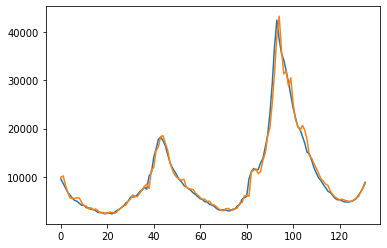

In [79]:
def test_loop(dataloader, model):
    yearLow = 2013
    yearHigh = 2020
    df = pd.read_csv("data\FluViewPhase2Data\WHO_NREVSS_Combined_prior_to_2015_16.csv")
    df = df[(yearLow <= df["YEAR"]) & (df["YEAR"] < yearHigh)]["TOTAL"]
    data = np.array(df)
    numFeat = 10 #------------------------
    numOut = 1

    size = len(data)-numFeat-numOut
    
    with torch.no_grad():
        for idx in range(4,len(test_data)):
            feat = test_data[idx][0]
            y = test_data[idx][1]
            X = feat[None,:,None]
            pred = model(X).squeeze().numpy()
            plt.plot(np.append(feat,pred))
            plt.plot(np.append(feat,y))
            
            plt.show()

def graph(model):
    with torch.no_grad():
        predY = []
        actY = []
        for idx in range(len(test_data)):
            feat = test_data[idx][0]
            y = test_data[idx][1]
            X = feat[None,:,None]
            pred = model(X).squeeze().numpy()
            predY.append(pred)
            actY.append(y)
            # plt.plot(np.append(feat,pred))
            # plt.plot(np.append(feat,y))
            
            
        
        plt.plot(actY) 
        plt.plot(predY)
        plt.show()

# test_loop(test_dataloader,model)
graph(model)
